In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import constants as const
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.coordinates import SkyCoord
from astropy import units as u
import csv
import os
from scipy.interpolate import CubicSpline as cs

pi = np.pi
AU = const.au.value

LAT = np.radians(-30.-(14./60.)-(40.68/3600.))
LONG = np.radians(-70.-(44./60.)-(57.90/3600.))

# Get orbit data

In [2]:
MAINPATH = '/home/devin/Documents/ISOAnalysis-main/iso_data/'
os.chdir(MAINPATH)

NDETECT = len(os.listdir())
NSAMPLES = 100000
NTIMES = 100

SING_KEYS = ['id', 'a', 'e', 'inc', 'Omega', 'omega', 'f', 'b']
MULTI_KEYS = ['time', 'year', 'month', 'day', 'sid_time', 'ra', 'dec', \
             'az', 'alt', 'ra_sun', 'dec_sun', 'az_sun', 'alt_sun', \
             'x', 'y', 'z', 'vx', 'vy', 'vz', 'mag', 'dist']

print('%d ISOs with minimum apparent magnitude lower than 24' %NDETECT)
print('%.3f %% rate' %(NDETECT/NSAMPLES*100))

6938 ISOs with minimum apparent magnitude lower than 24
6.938 % rate


In [3]:
def get_key(keyname):
    in_sing_keys = keyname in SING_KEYS
    if in_sing_keys:
        ind = SING_KEYS.index(keyname)
        key = np.zeros(NDETECT)
    else:
        ind = MULTI_KEYS.index(keyname)
        key = np.zeros((NDETECT, NTIMES))
        
    for i, file in enumerate(os.listdir()):
        file_path = MAINPATH + 'particle_' + str(i) + '.csv'
        with open(file_path, 'r') as infile:
            reader = csv.reader(infile)
            rows = list(reader)
            if in_sing_keys:
                key[i] = rows[1][ind]
            else:
                key[i] = np.array(rows[4:])[:, ind]        
    return key

orbits = {}
for key in np.concatenate((SING_KEYS, MULTI_KEYS)):
    orbits[key] = get_key(key)

In [4]:
orbits['datetime'] = np.dstack((orbits['year'], orbits['month'], \
                                    orbits['day']))
orbits['pos_eq'] = np.dstack((orbits['ra'], orbits['dec']))
orbits['pos_horiz'] = np.dstack((orbits['az'], orbits['alt']))
orbits['solar_pos_eq'] = np.dstack((orbits['ra_sun'], orbits['dec_sun']))
orbits['solar_pos_horiz'] = np.dstack((orbits['az_sun'], orbits['alt_sun']))
orbits['rad'] = np.dstack((orbits['x'], orbits['y'], orbits['z']))
orbits['vel'] = np.dstack((orbits['vx'], orbits['vy'], orbits['vz']))

In [5]:
os.chdir('/home/devin/Documents/ISOAnalysis-main/')

# Find distributions

In [6]:
min_dist = np.zeros(NDETECT)
min_dist_time = np.zeros_like(min_dist)
for i in range(NDETECT):
    spl = cs(orbits['time'][i], orbits['dist'][i])
    new_times = np.linspace(np.min(orbits['time'][i]), \
                           np.max(orbits['time'][i]), 1000000)
    min_dist[i] = np.min(spl(new_times))
    min_dist_time[i] = new_times[spl(new_times)==min_dist[i]][0]

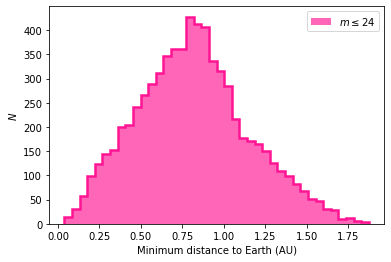

In [7]:
plt.hist(min_dist, bins='auto', color='deeppink', alpha=0.65, \
        label=r'$m\leq 24$')
plt.hist(min_dist, bins='auto', edgecolor='deeppink', fill=None, \
        lw=2.5, histtype='step')

plt.xlabel('Minimum distance to Earth (AU)')
plt.ylabel(r'$N$')

plt.legend(loc='upper right')

plt.savefig('figures/min_dist_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

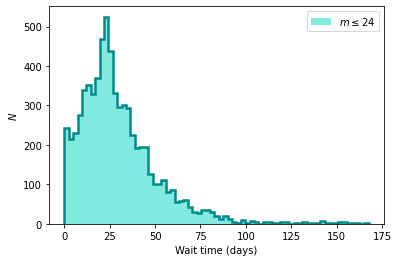

In [8]:
waittime = np.zeros(NDETECT)
for i in range(NDETECT):
    det_ind = np.where(orbits['mag'][i] <= 24.)[0][0]
    waittime[i] = np.abs(orbits['time'][i][det_ind] - \
                      min_dist_time[i])
waittime = waittime/(60*60*24)

plt.hist(waittime, bins='auto', color='turquoise', alpha=0.65, \
        label=r'$m\leq 24$')
plt.hist(waittime, bins='auto', edgecolor='darkcyan', fill=None, \
        lw=2.5, histtype='step')

plt.xlabel('Wait time (days)')
plt.ylabel(r'$N$')

plt.legend(loc='upper right')
plt.savefig('figures/waittime_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show() 

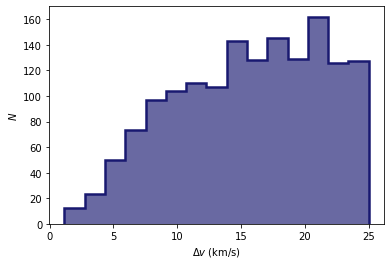

In [9]:
dv = (min_dist*AU/1000.)/(waittime*24*60*60)

plt.hist(dv[dv <= 25.], bins='auto', color='midnightblue', alpha=0.65)
plt.hist(dv[dv <= 25.], bins='auto', edgecolor='midnightblue', fill=None, \
        lw=2.5, histtype='step')

plt.xlabel(r'$\Delta v$ (km/s)')
plt.ylabel(r'$N$')

plt.savefig('figures/deltav_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

In [10]:
low_dv = dv <= 20

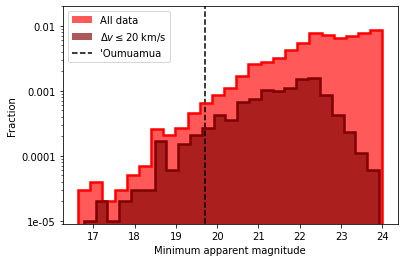

In [11]:
min_mag = np.min(orbits['mag'], axis=1)

plt.vlines(19.7, 0, 2000, label="'Oumuamua", linestyles='dashed', \
          colors='black')

plt.hist(min_mag, bins=25, color='red', alpha=0.65, \
       label='All data')
plt.hist(min_mag, bins=25, edgecolor='red', fill=None, \
       histtype='step', lw=2.5)
plt.hist(min_mag[low_dv], bins=25, color='maroon', \
       alpha=0.65, label=r'$\Delta v\leq 20$ km/s')
plt.hist(min_mag[low_dv], bins=25, edgecolor='maroon', \
       fill=None, histtype='step', lw=2.5)

plt.xlabel('Minimum apparent magnitude')
plt.ylabel('Fraction')
plt.yscale('log')
plt.ylim(9*10**-1, 2*10**3)
plt.yticks([10**0, 10**1, 10**2, 10**3], \
           np.array([1, 10, 100, 1000])/NSAMPLES)

plt.legend(loc='upper left')
plt.savefig('figures/min_mag_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

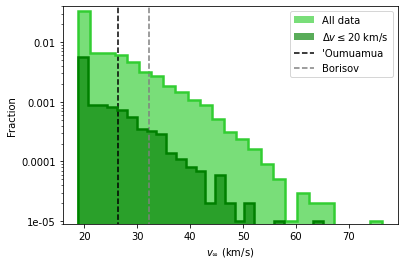

In [12]:
v_init = np.linalg.norm(orbits['vel'][:, 0], axis=1)*AU/1000.

plt.vlines(26.33, 0, 5000, label="'Oumuamua", linestyles='dashed', \
          colors='black')
plt.vlines(32.2, 0, 5000, label="Borisov", linestyles='dashed', \
          colors='grey')

plt.hist(v_init, bins=25, color='limegreen', alpha=0.65, \
       label='All data')
plt.hist(v_init, bins=25, edgecolor='limegreen', fill=None, \
       histtype='step', lw=2.5)
plt.hist(v_init[low_dv], bins=25, color='green', \
       alpha=0.65, label=r'$\Delta v\leq 20$ km/s')
plt.hist(v_init[low_dv], bins=25, edgecolor='green', \
       fill=None, histtype='step', lw=2.5)

plt.xlabel(r'$v_{\infty}$ (km/s)')
plt.ylabel('Fraction')
plt.yscale('log')
plt.ylim(9*10**-1, 4*10**3)
plt.yticks([10**0, 10**1, 10**2, 10**3], \
           np.array([1, 10, 100, 1000])/NSAMPLES)

plt.legend(loc='upper right')
plt.savefig('figures/v_init_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

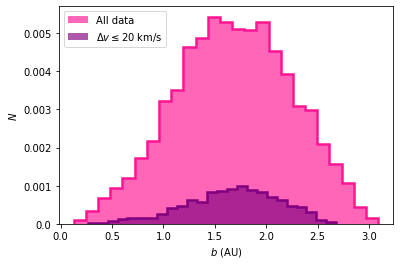

In [13]:
plt.hist(orbits['b'], bins=25, color='deeppink', alpha=0.65, \
       label='All data')
plt.hist(orbits['b'], bins=25, edgecolor='deeppink', fill=None, \
       histtype='step', lw=2.5)
plt.hist(orbits['b'][low_dv], bins=25, color='purple', \
       alpha=0.65, label=r'$\Delta v\leq 20$ km/s')
plt.hist(orbits['b'][low_dv], bins=25, edgecolor='purple', \
       fill=None, histtype='step', lw=2.5)

plt.xlabel(r'$b$ (AU)')
plt.ylabel(r'$N$')

plt.yticks([0, 100, 200, 300, 400, 500], \
           np.array([0, 100, 200, 300, 400, 500])/NSAMPLES)

plt.legend(loc='upper left')
plt.savefig('figures/b_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

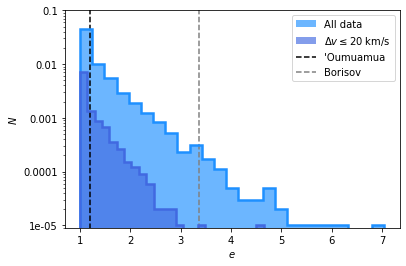

In [14]:
plt.vlines(1.201, 0, 50000, label="'Oumuamua", linestyles='dashed', \
          colors='black')
plt.vlines(3.357, 0, 50000, label="Borisov", linestyles='dashed', \
          colors='grey')

plt.hist(orbits['e'], bins=25, color='dodgerblue', alpha=0.65, \
       label='All data')
plt.hist(orbits['e'], bins=25, edgecolor='dodgerblue', fill=None, \
       histtype='step', lw=2.5)
plt.hist(orbits['e'][low_dv], bins=25, color='royalblue', \
       alpha=0.65, label=r'$\Delta v\leq 20$ km/s')
plt.hist(orbits['e'][low_dv], bins=25, edgecolor='royalblue', \
       fill=None, histtype='step', lw=2.5)

plt.xlabel(r'$e$')

plt.ylabel(r'$N$')
plt.yscale('log')
plt.ylim(9*10**-1, 4*10**3)
plt.yticks([10**0, 10**1, 10**2, 10**3, 10**4], \
           np.array([1, 10, 100, 1000, 10000])/NSAMPLES)

plt.legend(loc='upper right')
plt.savefig('figures/e_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

In [15]:
detectable = (orbits['mag'] <= 24)*(orbits['pos_horiz'][:, :, 1] > np.radians(30.))*(orbits['solar_pos_horiz'][:, :, 1] < np.radians(-18.))
detectable = np.any(detectable==True, axis=1)
nobs = len(detectable[detectable==True])
        
print('Detections: %d' %nobs)
print('Detection rate: %.3f %%' %(nobs/NSAMPLES*100))

Detections: 2568
Detection rate: 2.568 %


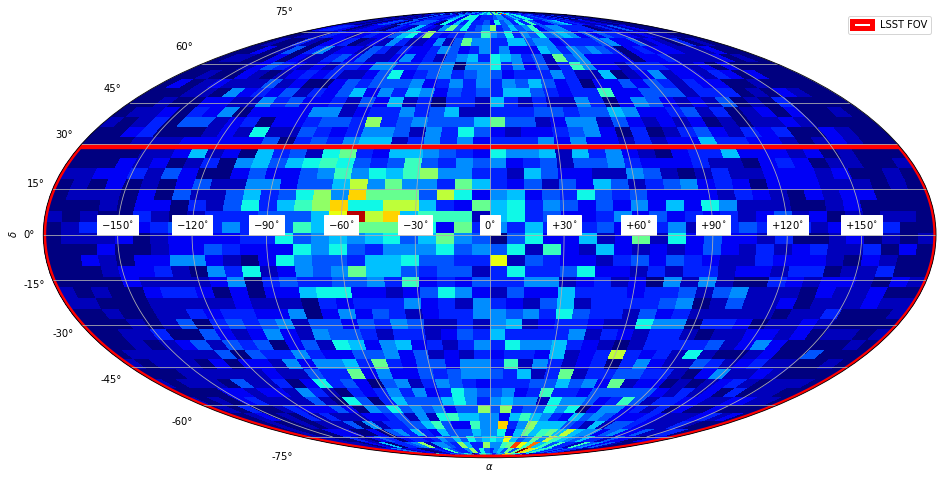

In [16]:
from matplotlib.patches import Rectangle

det_pos = []
lsst_pos = []
lsst_mag = []
for i in range(NDETECT):
    det = orbits['mag'][i] <= 24.
    lsst = det*(orbits['pos_horiz'][i][:, 1] > np.radians(30.))*\
        (orbits['solar_pos_horiz'][i][:, 1] < np.radians(-18.))
    if True in det:
        j = np.where(orbits['mag'][i][det] == orbits['mag'][i][det][0])
        det_pos.append(orbits['pos_eq'][i][det][j])
    if True in lsst:
        j = np.where(orbits['mag'][i][lsst] == orbits['mag'][i][lsst][0])
        lsst_pos.append(orbits['pos_eq'][i][lsst][j])
        lsst_mag.append(orbits['mag'][i][lsst][j])
            
det_pos = np.reshape(det_pos, (NDETECT, 2))
lsst_pos = np.reshape(lsst_pos, (nobs, 2))
lsst_mag = np.reshape(lsst_mag, nobs)
    
fig = plt.figure(figsize=(16, 10))
ax = plt.subplot(111, projection='mollweide')

H, xedges, yedges = np.histogram2d(det_pos[:, 0], det_pos[:, 1], bins=50)
im = ax.pcolormesh(xedges, yedges, H, cmap='jet', shading='auto')

ax = plt.gca()
ax.add_patch(Rectangle((np.min(lsst_pos[:, 0]), np.min(lsst_pos[:, 1])), \
    np.max(lsst_pos[:, 0])-np.min(lsst_pos[:, 0]), \
    np.max(lsst_pos[:, 1])-np.min(lsst_pos[:, 1]), \
    fill=None, lw=5, edgecolor='red', label='LSST FOV'))

plt.xlabel(r'$\alpha$')
plt.xticks([-5*pi/6, -2*pi/3, -pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6], [ \
        r'$-150^{\circ}$', r'$-120^{\circ}$', r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', r'$0^{\circ}$', \
        r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$', r'$+120^{\circ}$', r'$+150^{\circ}$'], \
        backgroundcolor='white')

plt.ylabel(r'$\delta$')
plt.grid(True)
plt.legend(loc='upper right')

plt.savefig('figures/detectable_pos.pdf', bbox_inches='tight', dpi=250)
plt.show()

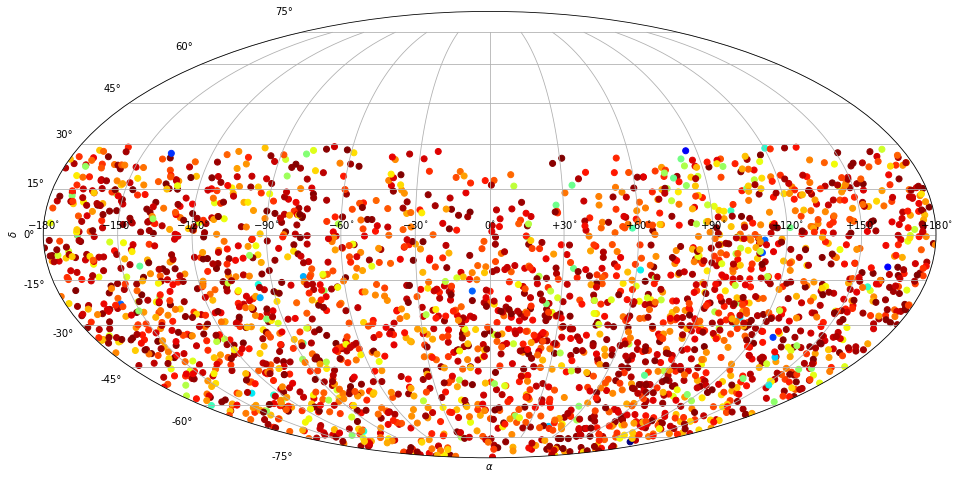

In [17]:
plt.figure(figsize=(16,10))
ax = plt.subplot(111, projection='mollweide')

ax.scatter(lsst_pos[:, 0], lsst_pos[:, 1], c=lsst_mag, cmap='jet')

plt.xlabel(r'$\alpha$')
plt.xticks([-pi, -5*pi/6, -2*pi/3, -pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6, pi], [r'$-180^{\circ}$', \
        r'$-150^{\circ}$', r'$-120^{\circ}$', r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', r'$0^{\circ}$', \
        r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$', r'$+120^{\circ}$', r'$+150^{\circ}$', r'$+180^{\circ}$'])

plt.ylabel(r'$\delta$')
plt.grid(True)

plt.savefig('figures/lsst_scatter.pdf', bbox_inches='tight', dpi=250)
plt.show()

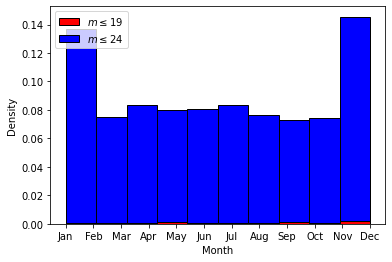

In [18]:
det_month = np.zeros(NDETECT)
for i in range(NDETECT):
    det_month[i] = orbits['datetime'][i][orbits['mag'][i] == \
                    orbits['mag'][i][det_ind]][0][1]

c = ['red', 'blue']
plt.hist([det_month[min_mag <= 19.], det_month[min_mag <= 24.]], \
         stacked=True, color=c, edgecolor='k', density=True, \
        label=[r'$m\leq 19$', r'$m\leq 24$'])

plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', \
                             'May', 'Jun', 'Jul', 'Aug', 'Sep', \
                              'Oct', 'Nov', 'Dec'])
plt.xlabel('Month')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.savefig('figures/month_detect.pdf', bbox_inches='tight', dpi=250)
plt.show()